# Volume Reversal Strategy

A trading strategy based on price movements corresponding to the trading volume.

### Import libraries

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

### Stock Data 

In [43]:
data = pd.read_csv('./data/GSPC.csv', index_col=['Date'], parse_dates=True, usecols=['Date','Adj Close','Volume'])
data.head()

,Adj Close,Volume
Date,,
2000-03-08,1366.699951,1203000000
2000-03-09,1401.689941,1123000000
2000-03-10,1395.069946,1138800000
2000-03-13,1383.619995,1016100000
2000-03-14,1359.150024,1094000000


In [44]:

data.head()

,Adj Close,Volume
Date,,
2000-03-08,1366.699951,1203000000
2000-03-09,1401.689941,1123000000
2000-03-10,1395.069946,1138800000
2000-03-13,1383.619995,1016100000
2000-03-14,1359.150024,1094000000


### Price change for the last 5 days

In [45]:
data['pr_chg_5d'] = data['Adj Close'].shift(1) - data['Adj Close'].shift(6)
data.head(10)

,Adj Close,Volume,pr_chg_5d
Date,,,
2000-03-08,1366.699951,1203000000,NaN
2000-03-09,1401.689941,1123000000,NaN
2000-03-10,1395.069946,1138800000,NaN
2000-03-13,1383.619995,1016100000,NaN
2000-03-14,1359.150024,1094000000,NaN
2000-03-15,1392.140015,1302800000,NaN
2000-03-16,1458.469971,1482300000,25.440064
2000-03-17,1464.469971,1295100000,56.780030
2000-03-20,1456.630005,920800000,69.400025


### Standard Deviation of 5d Price Change 

In [46]:
data['std_100d'] = data['pr_chg_5d'].rolling(window=100).std()

### Average Volume Traded
Calculate the last 5day's average traded volume

In [47]:
data['avg_vol_5d'] = data['Volume'].shift(1).rolling(window=5).mean()

### Average Volume Traded between last 5 - 10 days 

In [48]:
data['avg_vol_5d_10d'] = data['avg_vol_5d'].shift(5)

### Signal Column
Initialise the signal col to 0

In [49]:
data['signal'] = 0

## Buy Signal
A signal to buy will be triggered when:
1. abs(pr_chg_5d) > std_100d   
2. avg_vol_5d < avg_vol_5d_10d 
3. pr_chg_5d < 0

In [50]:
data.loc[(data['pr_chg_5d'].abs() > data['std_100d']) & \
         (data['avg_vol_5d'] < data['avg_vol_5d_10d']) & \
         (data['pr_chg_5d'] < 0), 'signal'] = 1

## Sell Signal
A signal to sell will be triggered when:
1. abs(pr_chg_5d) > std_100d
2. avg_vol_5d < avg_vol_5d_10d
3. pr_chg_5d > 0

In [51]:
data.loc[(data['pr_chg_5d'].abs() > data['std_100d']) & \
         (data['avg_vol_5d'] < data['avg_vol_5d_10d']) & \
         (data['pr_chg_5d'] > 0), 'signal'] = -1

## Entry and Exit signal
Here we check for the last entry signal: 
if the signal is more than 5 days old:
    exit the position
else
    hold it until the signal is 5 days old or there's a counter signal

In [52]:
data['c_signal']=0 
data['exit']=0

In [53]:
for i in range(len(data)):
    if((data.iloc[i]['signal']!=0) &(data.iloc[i]['signal']!= data.iloc[i-1]['c_signal'])) :
        data.iloc[i,data.columns.get_loc('c_signal')]=data.iloc[i,data.columns.get_loc('signal')]
        if data['signal'][i] ==1:
            data.iloc[i,data.columns.get_loc('exit')]=1
        else:
            data.iloc[i,data.columns.get_loc('exit')]=-1
    if((data['signal'][i]!=0) & (data['signal'][i]== data['c_signal'][i-1])) :
        data.iloc[i,data.columns.get_loc('c_signal')]=data['c_signal'][i-1]
        if data['c_signal'][i-1]==1:
               data.iloc[i,data.columns.get_loc('exit')]=int(data['exit'][i-1])+1
        else:
            data.iloc[i,data.columns.get_loc('exit')]=int(data['exit'][i-1])-1
    if((data['signal'][i]==0)&(data['exit'][i-1]<5)&(data['exit'][i-1]>0)):    
        data.iloc[i,data.columns.get_loc('c_signal')]=data['c_signal'][i-1]
        data.iloc[i,data.columns.get_loc('exit')]=int(data['exit'][i-1])+1
    if((data['signal'][i]==0)&(data['exit'][i-1]>-5)&(data['exit'][i-1]<0)):    
        data.iloc[i,data.columns.get_loc('c_signal')]=data['c_signal'][i-1]
        data.iloc[i,data.columns.get_loc('exit')]=int(data['exit'][i-1])-1
    if((data['signal'][i]==0)&((data['exit'][i-1]==5)|(data['exit'][i-1]==-5))):    
        data.iloc[i,data.columns.get_loc('c_signal')]=0
        data.iloc[i,data.columns.get_loc('exit')]=0

In [62]:
data[data['c_signal'] != 0].head()

,Adj Close,Volume,pr_chg_5d,std_100d,avg_vol_5d,avg_vol_5d_10d,signal,c_signal,exit,return,str_return,cu_str_return,cu_mar_return
Date,,,,,,,,,,,,,
2000-08-08,1482.800049,992200000,48.489990,46.605287,967920000.0,1.058840e+09,-1,-1,-1,0.002350,-0.002350,-0.002350,0.043353
2000-08-09,1472.869995,1054000000,44.700073,46.481018,978620000.0,1.052700e+09,0,-1,-2,-0.006719,0.006719,0.004370,0.036633
2000-08-10,1460.250000,940800000,34.170044,46.106798,990520000.0,1.004440e+09,0,-1,-3,-0.008605,0.008605,0.012975,0.028028
2000-08-11,1471.839966,835500000,7.689941,45.563381,959560000.0,9.922800e+08,0,-1,-4,0.007906,-0.007906,0.005069,0.035934
2000-08-14,1491.560059,783800000,8.909912,43.562302,935460000.0,9.874800e+08,0,-1,-5,0.013309,-0.013309,-0.008240,0.049243


In [55]:
data['return'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))

In [56]:
data['str_return']=data['return']*data['c_signal']

In [57]:
data['cu_str_return']=0
data['cu_mar_return']=0

In [58]:
data.iloc[100:,data.columns.get_loc('cu_str_return')]=pd.expanding_sum(data['str_return'][100:])

C:\non-System\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  """Entry point for launching an IPython kernel.


In [59]:
data.iloc[100:,data.columns.get_loc('cu_mar_return')]=pd.expanding_sum(data['return'][100:])

C:\non-System\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  """Entry point for launching an IPython kernel.


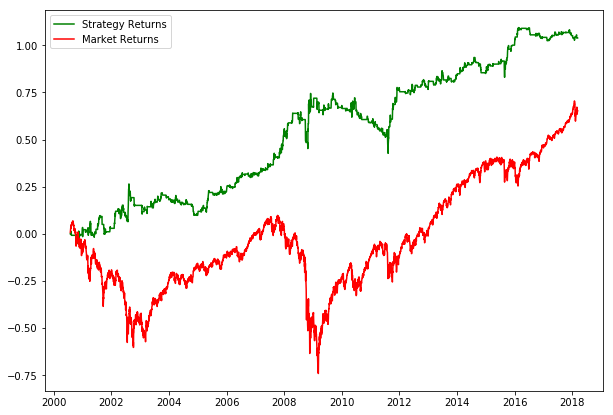

In [60]:
plt.figure(figsize=(10,7))
plt.plot(data['cu_str_return'][100:], color='g',label='Strategy Returns')
plt.plot(data['cu_mar_return'][100:], color='r',label='Market Returns')
plt.legend(loc='best')
plt.show()

In [61]:
(data['cu_str_return'].iloc[-1]-data['cu_mar_return'].iloc[-1])/data['cu_str_return'].std()

1.0979823270741023